# Feed Forward Neural Network for Rogue Wave Prediction

***Model motivation and approach***

In this notebook, we use a Feed Forward Neural Network (FFNN) to predict rogue wave characteristics. FFNNs are universal function approximators capable of learning highly nonlinear relationships between input features and target variables. Unlike tree-based ensembles, which partition the feature space, or SVMs, which rely on distance-based kernels, FFNNs learn continuous, multi-layer feature transformations that can uncover complex interactions and subtle patterns in high-dimensional data. This makes them particularly suitable when the underlying physical processes are nonlinear, multi-factorial, and difficult to capture with traditional parametric models.

***Model Training***

We implement a multi-layer perceptron using the Keras Sequential API, with all input features scaled to the [0, 1] range using the `MinMaxScaler` from scikit-learn. Proper scaling ensures numerical stability during gradient-based optimization and helps the network learn balanced representations across features. The architecture consists of three fully connected hidden layers with 512, 256, and 256 units, each using the ReLU activation function. To reduce overfitting, we apply a dropout rate of 0.1, randomly dropping units and their connections during training. The output layer uses a linear activation function appropriate for continuous regression targets such as the Abnormality Index. The network is trained using mean squared error (MSE) loss and the Adam optimiser with a learning rate of 0.02. We use a batch size of 1024 and train for up to 1000 epochs, applying early stopping with a patience of 50 epochs to halt training when no further validation improvements occur.

Given the high computational cost of deep neural networks, we do not perform an exhaustive grid search over hyperparameters. Instead, several architectures and learning rates were evaluated manually, and the selected configuration provided the best balance between stability, training time, and predictive performance.


***Model Evaluation***

To assess predictive performance, we compute:

- **MSE** — sensitive to large errors  
- **MAE** — robust average deviation  
- **R² score** — explained variance  
- **Spearman correlation** — preserves rank information even when relationships are not strictly linear  

Together, these metrics provide a comprehensive view of model accuracy and stability.


***Model Interpretation***

We use SHAP (SHapley Additive exPlanations) to interpret the Random Forest model. SHAP values provide:

- **Global feature importance** — which variables the model relies on most  
- **Local explanations** — how individual features contribute to a specific prediction  
- **Interaction insights** — how combinations of features influence model behaviour  

To interpret the FFNN, we apply SHAP using the `DeepExplainer`, a method designed specifically for deep learning models. Unlike tree-based or linear explainers that rely on model structure, `DeepExplainer` uses backpropagation-based approximations of Shapley values to attribute contributions of each feature to the network’s output. We use a background dataset of **2,000 randomly sampled waves** to approximate the data distribution for SHAP integration. 

SHAP values are computed for:

- **160,000 training waves**  
- **40,000 test waves**

Training-set SHAP values reflect learned dependencies, while test-set values show how well these dependencies generalize. Comparing both sets helps identify overfitting and highlights which features consistently drive predictions across unseen data.

***Conclusion***

The Feed Forward Neural Network shows noticeably weaker predictive performance compared to the tree-based and kernel-based models. Both the training and test results yield R² values around 0.83 and Spearman correlations below 0.90, indicating that the network captures only part of the nonlinear structure governing wave abnormality. The similar performance across training and test sets suggests that the model generalizes reasonably well, but its capacity is insufficient to extract the more subtle relationships present in the data. 

The SHAP analyses for both training and test sets reveal a coherent importance ranking dominated by BFI, gust and wind speed, kh, and steepness. However, the SHAP values are much larger in magnitude and far more widely dispersed than in the earlier models, indicating that the FFNN reacts much more strongly and inconsistently to individual features. This spread suggests that the network has not learned a stable internal representation and instead relies on highly variable feature interactions across the dataset. The beeswarm plots show broad, overlapping distributions across features, indicating that the network relies heavily on diffuse interactions rather than clean, structured dependencies. This diffuse behaviour is further emphasized by the partial dependence plots, which display complex but noisy nonlinear relationships. Many features show oscillatory or irregular patterns rather than smooth monotonic effects, suggesting that the network is fitting unstable higher-order interactions rather than robust physical relationships. This suggests that deeper architectures, regularization strategies, or alternative neural-network designs would be necessary to approach the performance and interpretability achieved by the best-performing models in this study.


**Imports**

In [1]:
import os
import sys
import pickle
import shap

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras import models


sys.path.append('./')
sys.path.append('../scripts/')
import utils

To reproduce the trained model results and evaluate the SHAP values, please download the precomputed model outputs using the code snippet below. The archive contains all necessary files, including the trained model and SHAP results.

The downloaded archive contains the following files:

* `model_and_data.pkl` – trained model and associated dataset
* `model.keras` – stored model weights
* `train_shap.pkl` – SHAP values for the training set
* `test_shap.pkl` – SHAP values for the test set

These files allow you to load the trained model directly and reproduce all evaluation and SHAP analyses without retraining.

In [ ]:
# dir_output = "../results/"
# os.makedirs(dir_output, exist_ok=True)

# download zip file from link below. 
# url = "https://github.com/HelmholtzAI-Consultants-Munich/rogue_wave_prediction/releases/latest/download/ffnn.zip"
# with open(f"{dir_output}/ffnn.zip", "wb") as f:
#     f.write(requests.get(url).content)

# with zipfile.ZipFile(f"{dir_output}/ffnn.zip", 'r') as zip_ref:
#     zip_ref.extractall(dir_output)

**Data Loading**

We load the data that was preprocessed in `01_data_processing.ipynb`.  

In [2]:
file_data = "../data/data_train_test.pickle"  # path to the preprocessed data
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(file_data)

Loading data...

Training dataset target distribution:
Counter({1: 489544, 0: 334909, 2: 14264})

Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})


**Data Standardization**

In [3]:
scaler = MinMaxScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

**Model Training**

In [4]:
# we run the ffnn model on GPU and load the trained model here
file_model = "../results/ffnn/model.keras"
model = models.load_model(file_model)

**Model Evaluation**

26210/26210 ━━━━━━━━━━━━━━━━━━━━ 11s 405us/step
Evaluate on Training Set


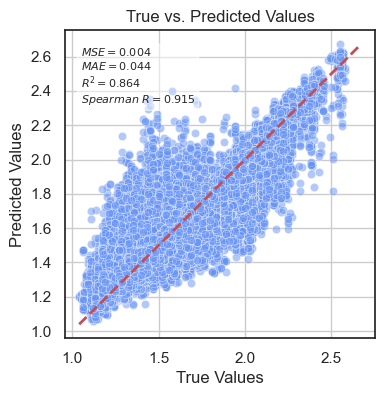

6553/6553 ━━━━━━━━━━━━━━━━━━━━ 3s 399us/step
Evaluate on Test Set


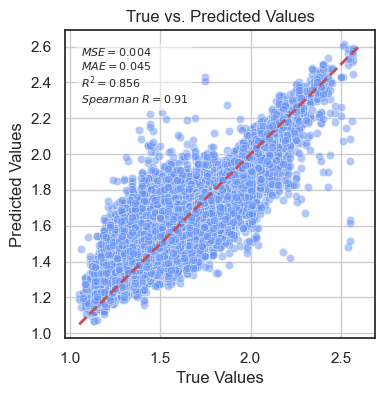

In [5]:
# Evaluate model on train and test set
_, _, _, _, _, _ = utils.evaluate_best_regressor(model, X_train_transformed, y_train, dataset="Training", plot=True)
_, _, _, _, _, _ = utils.evaluate_best_regressor(model, X_test_transformed, y_test, dataset="Test", plot=True)

In [6]:
# Save the model
data_train = pd.DataFrame(X_train_transformed, columns=X_train.columns)
data_train["AI_10min"] = y_train
data_train["AI_10min_cat"] = y_train_cat

data_test = pd.DataFrame(X_test_transformed, columns=X_test.columns)
data_test["AI_10min"] = y_test
data_test["AI_10min_cat"] = y_test_cat

data_and_model = [data_train, data_test, model]

file_data_model = f"../results/ffnn/model_and_data.pkl"
with open(file_data_model, 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

utils.get_model_size(model)

Model size on disk: 0.0030 GB


**Model Interpretation**

Interpretation on Training Set

In [7]:
file_shap = f"../results/ffnn/train_shap.pkl"

# Load and unpack the shap values
with open(file_shap, "rb") as handle:
    explanation_train = pickle.load(handle)

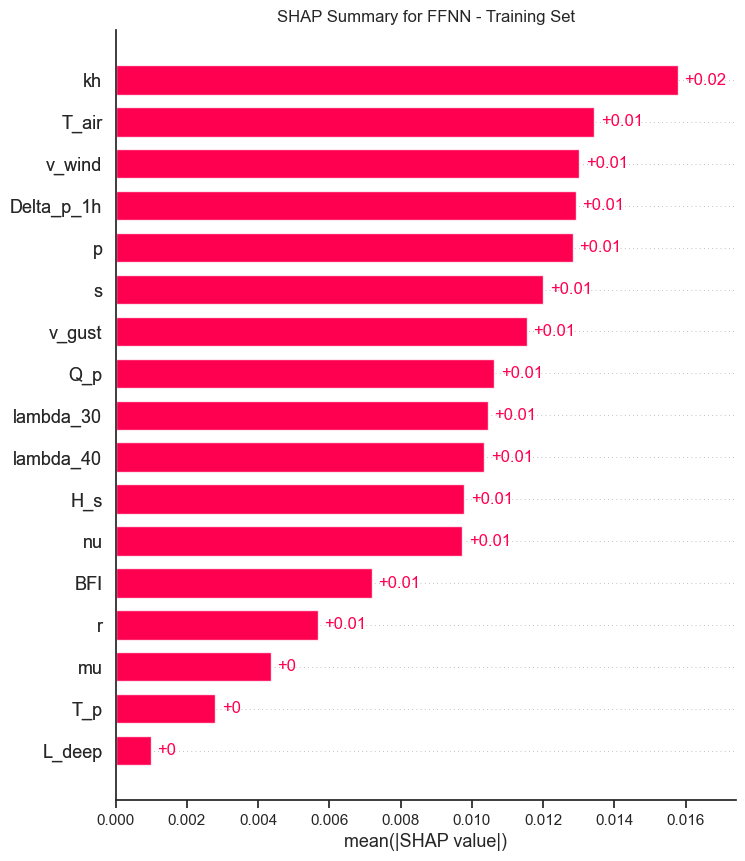

In [8]:
shap.plots.bar(explanation_train, max_display=17, show=False)
plt.title("SHAP Summary for FFNN - Training Set")
plt.show()

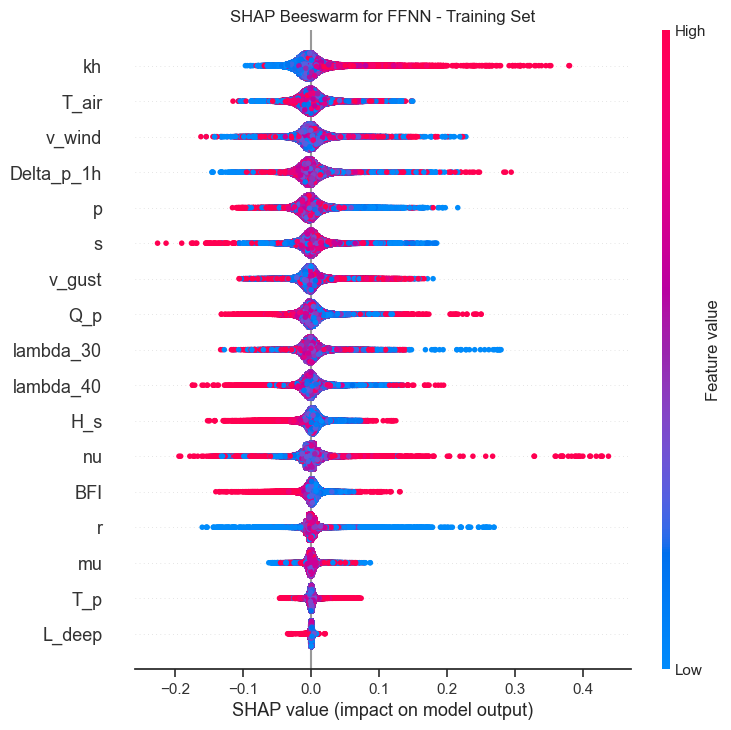

In [9]:
shap.plots.beeswarm(explanation_train, max_display=17, show=False)
plt.title("SHAP Beeswarm for FFNN - Training Set")
plt.show()

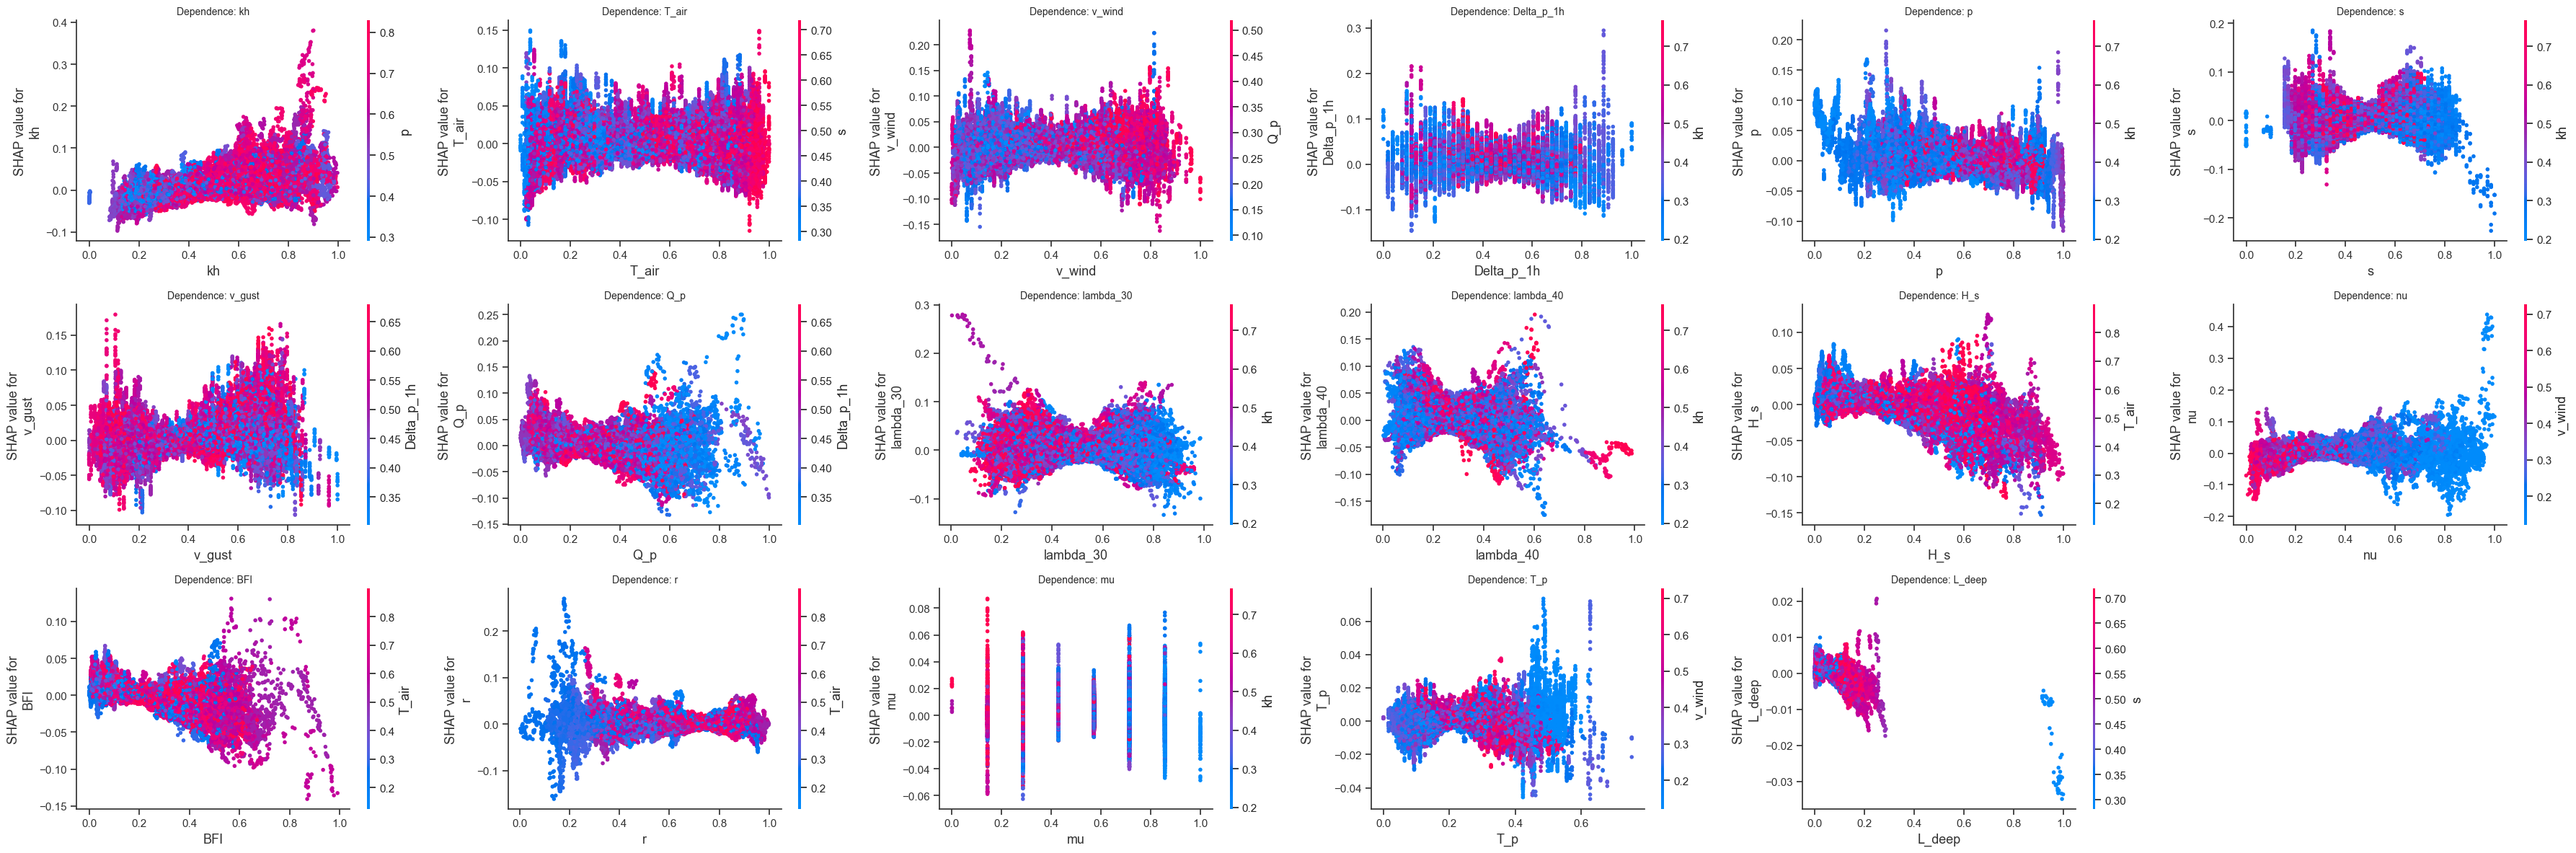

In [10]:
utils.plot_shap_dependence(explanation_train)

Interpretation on Test Set

In [11]:
file_shap = f"../results/ffnn/test_shap.pkl"

# Load and unpack the shap values
with open(file_shap, "rb") as handle:
    explanation_test = pickle.load(handle)

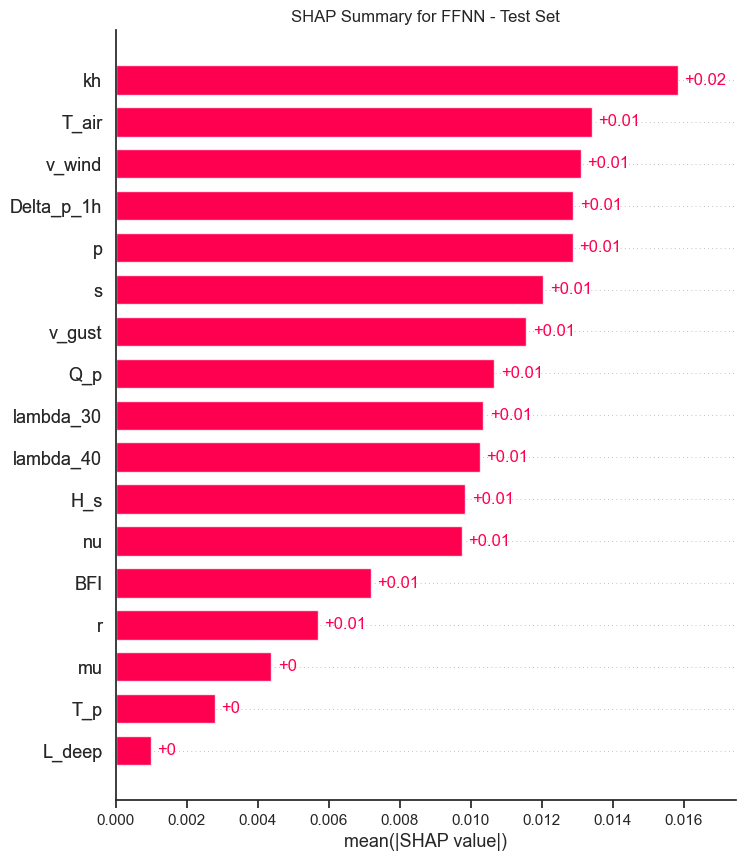

In [12]:
shap.plots.bar(explanation_test, max_display=17, show=False)
plt.title("SHAP Summary for FFNN - Test Set")
plt.show()

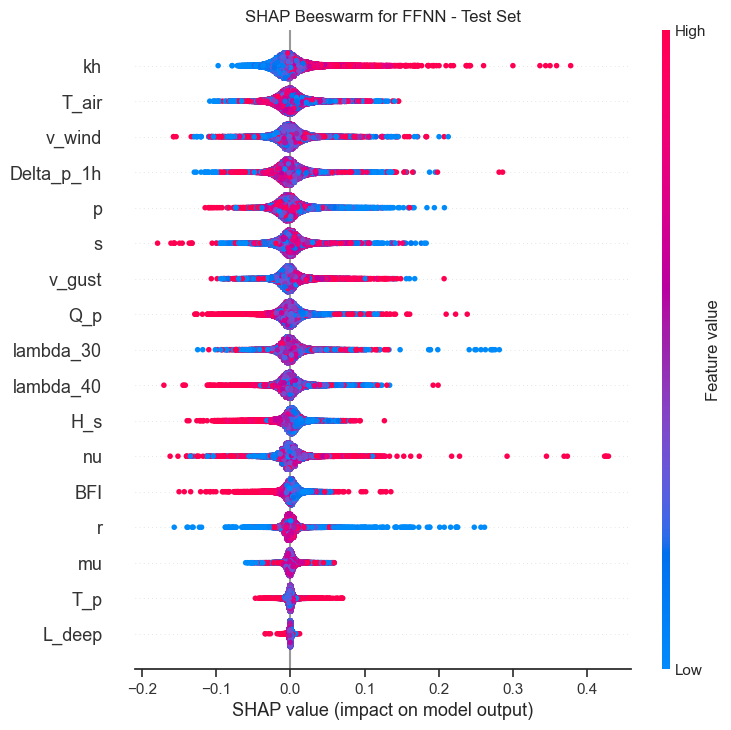

In [13]:
shap.plots.beeswarm(explanation_test, max_display=17, show=False)
plt.title("SHAP Beeswarm for FFNN - Test Set")
plt.show()

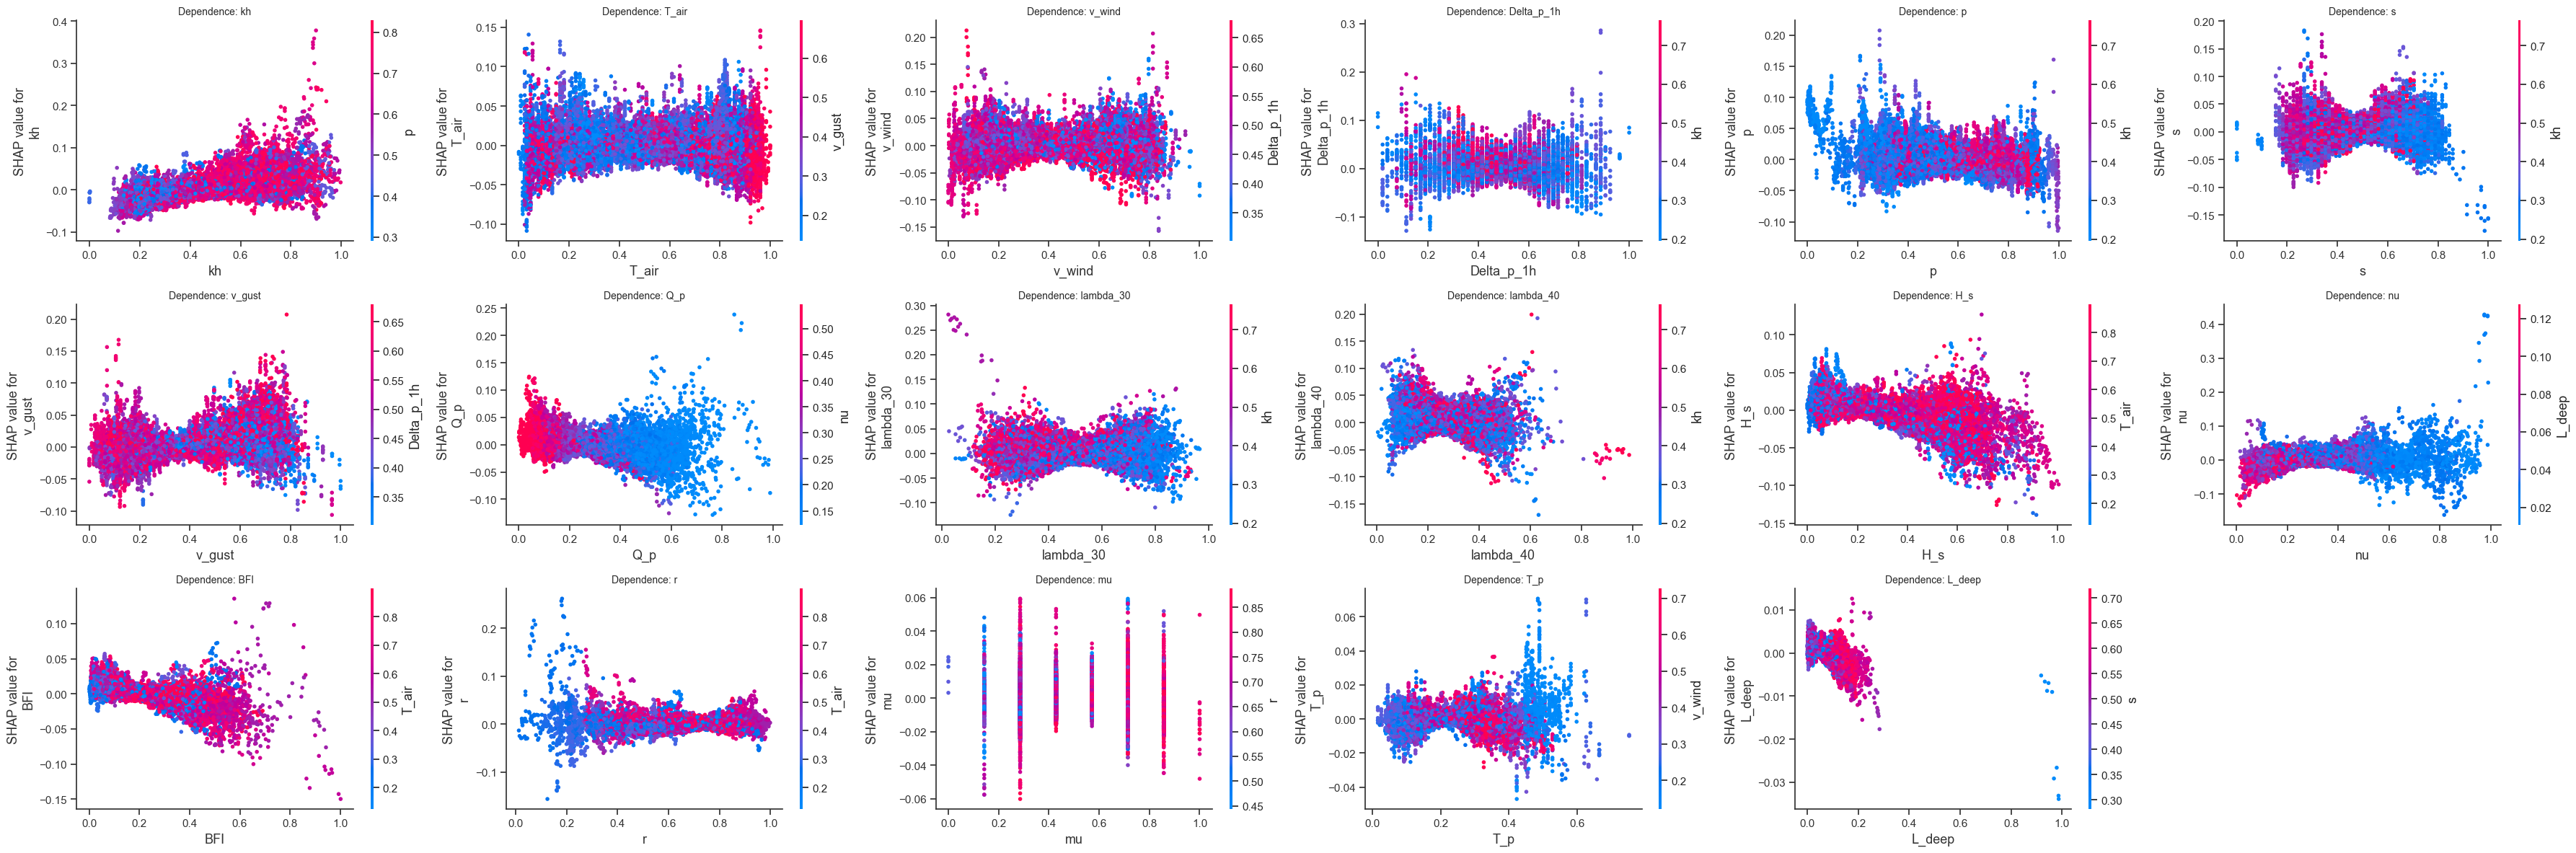

In [14]:
utils.plot_shap_dependence(explanation_test)